FIT SUPERVISED BOUNDARY LAYER CLASSIFICATION
=======================================

This notebook explains how the supervised boundary layer classifier are trained.
Take as input a labelled dataset as generated by `bl-identification.ipynb`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import time

from blcovid import utils
from blcovid import graphics

In [2]:
graphics.storeImages=False

Load dataset
------------

In [3]:
idflabelspath="../working-directories/3-identified-labels/IDFLABELS_2015_0219.PASSY2015_BT-T_linear_dz40_dt30_zmax2000.nc"

In [4]:
X_raw,z_common,t_common,rawlabl, lablid, lablnames = utils.load_dataset(idflabelspath,
            variables_to_load=['X_raw','altitude','time','rawlabels'],fields_to_load=['label_identification','label_long_names'])
labelid = eval(lablid)
lablnames = eval(lablnames)

In [5]:
prepParams = utils.load_preparation_params(idflabelspath)
predictors = prepParams[0]

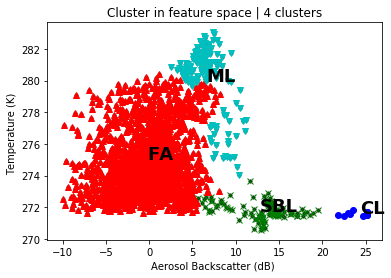

In [6]:
graphics.cluster2Dview(X_raw[:,0],predictors[0],X_raw[:,1],predictors[1],rawlabl,
            clustersIDs=labelid,displayClustersIDs=True)

Fit supervised models
---------------------

### Prepare cross-validation

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_raw,rawlabl,test_size=0.2, random_state=27)
print("Shape training set:",X_train.shape)
print("Shape testing set:",X_test.shape)
print("NaN checks:",np.isnan(X_train).sum(),np.isnan(X_test).sum(),np.isnan(y_train).sum(),np.isnan(y_test).sum())

Shape training set: (1689, 2)
Shape testing set: (423, 2)
NaN checks: 0 0 0 0


### Random forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

t0=time.time()      #::::::
rfc = RandomForestClassifier(n_estimators=50,max_depth=3)
rfc.fit(X_train,y_train)
print("Score:",rfc.score(X_test,y_test))
t1=time.time()      #::::::
print("Time to fit+score:",t1-t0,"(s)")

Score: 0.983451536643026
Time to fit+score: 0.09822297096252441 (s)


### Nearest neighbors

In [10]:
from sklearn.neighbors import KNeighborsClassifier
t0=time.time()      #::::::

knn=KNeighborsClassifier(n_neighbors=8)

knn.fit(X_train,y_train)
print("Score:",knn.score(X_test,y_test))
t1=time.time()      #::::::
print("Time to fit+score:",t1-t0,"(s)")

Score: 0.9952718676122931
Time to fit+score: 0.025849103927612305 (s)


### Decision tree

In [11]:
from sklearn.tree import DecisionTreeClassifier

t0=time.time()      #::::::
dtc = DecisionTreeClassifier(max_depth=5)
dtc.fit(X_train,y_train)
print("Score:",dtc.score(X_test,y_test))
t1=time.time()      #::::::
print("Time to fit+score:",t1-t0,"(s)")

Score: 0.9881796690307328
Time to fit+score: 0.005584716796875 (s)


### Adaptative tree boosting

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

t0=time.time()      #::::::
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),n_estimators=50)
abc.fit(X_train,y_train)
print("Score:",abc.score(X_test,y_test))
t1=time.time()      #::::::
print("Time to fit+score:",t1-t0,"(s)")

Score: 0.9905437352245863
Time to fit+score: 0.15703558921813965 (s)


### Label-propagation (semi-supervised)

In [13]:
from sklearn.semi_supervised import LabelSpreading

t0=time.time()      #::::::
lsc = LabelSpreading(kernel='knn')
lsc.fit(X_train,y_train)
print("Score:",lsc.score(X_test,y_test))
t1=time.time()      #::::::
print("Time to fit+score:",t1-t0,"(s)")

Score: 0.9952718676122931
Time to fit+score: 0.0954585075378418 (s)


Summarize performances
----------------------

In [14]:
classifiers =[rfc,knn,dtc,abc,lsc]
classifiers_keys =["rfc","knn","dtc","abc","lsc"]
n_randoms = 80
chronos = np.zeros((len(classifiers),n_randoms))
accuracies = np.zeros((len(classifiers),n_randoms))

In [16]:
for icl in range(len(classifiers)):
    clf = classifiers[icl]
    print("Classifier",icl+1,"/",len(classifiers),clf)
    for ird in range(n_randoms):
        X_train, X_test, y_train, y_test = train_test_split(X_raw,rawlabl,test_size=0.2, random_state=ird)
        
        t0=time.time()      #::::::
        clf.fit(X_train,y_train)
        accuracies[icl,ird]=clf.score(X_test,y_test)
        t1=time.time()      #::::::
        chronos[icl,ird]=t1-t0

Classifier 1 / 5 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Classifier 2 / 5 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')
Classifier 3 / 5 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split

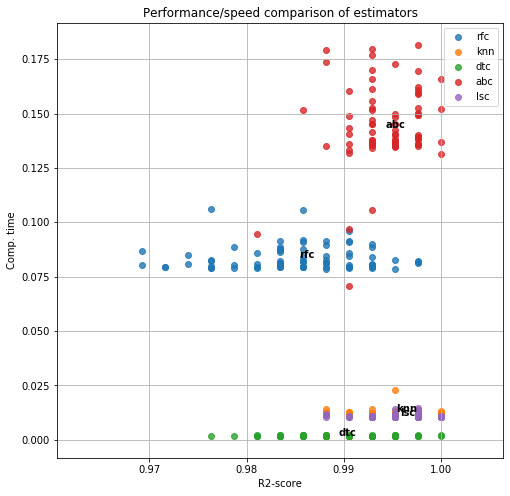

In [17]:
graphics.estimator_quality(accuracies,chronos,classifiers_keys)

Display the borders
-------------------

### Create background grid

Prepare comparison graphics...
Classifier 0 / 5 RandomForestClassifier
Classifier 1 / 5 KNeighborsClassifier
Classifier 2 / 5 DecisionTreeClassifier
Classifier 3 / 5 AdaBoostClassifier
Classifier 4 / 5 LabelSpreading


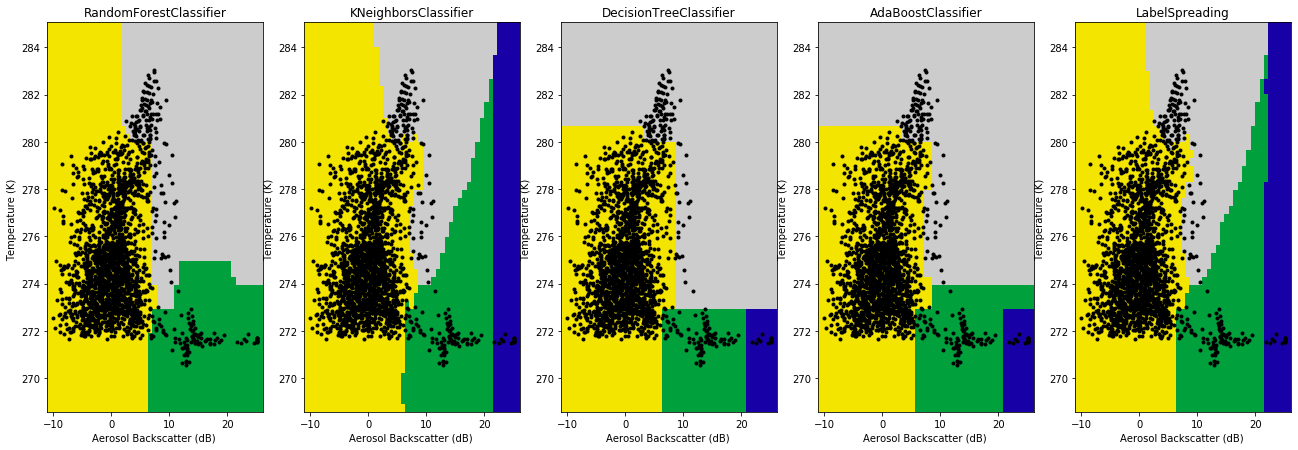

In [18]:
graphics.comparisonSupervisedAlgo(X_raw,classifiers)

Exports
-----------
### The selected classifier

In [20]:
import pickle
clf=dtc
clf.labelid_=labelid
storageDir="../working-directories/4-pre-trained-classifiers/"
namekey="_".join(idflabelspath.split('_')[2:-1])
dropfilename=str(clf).split('(')[0]+"."+namekey+".pkl"

In [21]:
fc=open(storageDir+dropfilename,'wb')
pickle.dump(clf,fc)
fc.close()